In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

images = ['balloons.jpg', 'candy.jpg', 'cat.jpg', 'ip.jpg', 
          'puppy.jpg', 'squirrel.jpg', 'tree.jpg']

def show_image(img):
    plt.imshow(img, interpolation='nearest')

In [2]:
'''This array contains the mosaiced images which have to be demosaiced.'''
mosaiced_images = []
gtruth_images = []

'''A function to generate the mosaiced images from the given RGB images.'''
def generate_mosaic(image):
    mosaic = image[:, :, 1].copy() # green
    mosaic[::2, ::2] = image[::2, ::2, 0] # red
    mosaic[1::2, 1::2] = image[1::2, 1::2, 2] # blue
    return mosaic
        
'''A function to generate the mosaiced images for all the input images.'''
def generate_input(mosaiced_images, gtruth_images):
    for file in images:
        image = imread('input/' + file)
        image = image / 255.0
        gtruth_images.append(image)
        mosaiced_images.append(generate_mosaic(image))
        
generate_input(mosaiced_images, gtruth_images)

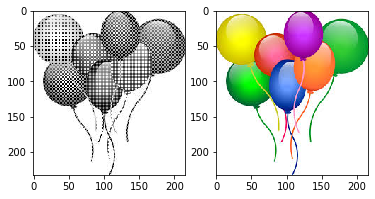

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(mosaiced_images[0], cmap='gray')
axarr[1].imshow(gtruth_images[0], cmap='gray')

In [4]:
def demosaic_nn(im):
    '''
    Implement your nearest neighbour code here.
    '''
    result_nn = np.zeros((im.shape[0], im.shape[1], 3))
    
    temp_image = np.zeros((im.shape[0],im.shape[1]))
    #G channel image
    #select the nearest left pixels of 
    #and if the nearest left pixel not exist, then choose the neartest right Green pixel  
    g_image = im.copy()
    #interpolation on R pixels
    #avoid the demention unmatchable
    g_image[::2,2::2] = im[::2,1:im.shape[1]-1:2] 
    '''
    #iteration solution
    i = 0
    j = 2
    while i < im.shape[0] and j < im.shape[1]:
        temp_image[i,j] = temp_image[i,j-1]
        i += 2
        j += 2
    '''
    #the leftest side of R pixels: choose the right nearest pixels
    temp_image[::2,0] = temp_image[::2,1]
    #interpolatio on B pixels
    g_image[1::2,1::2] = im[1::2,0:im.shape[1]-1:2]
    
    
    # R channel image
    r_image = im.copy()
    #interpolation of G pixels
    #same row : choose the left nearest r pixels
    r_image[::2,1::2] = im[::2,0:im.shape[1]-1:2]
    #same column: choose the top nearest r pixels
    r_image[1::2,0::2] = im[0:im.shape[0]-1:2,0::2]
    
    #interpolation of B pixels
    #choose the left nearst R pixels that originally are G pixels position 
    r_image[1::2,1::2] = r_image[1::2,0:im.shape[1]-1:2]
    
    
    # B channel image
    b_image = im.copy()
    #interpolation of G pixels
    #same row: choose the left nearest B pixels value
    b_image[1::2,2::2] = im[1::2,1:im.shape[1]-1:2]
    #the leftest G pixel: choose the right nearest B pixel
    b_image[1::2,0] = im[1::2,1]
    # same column
    b_image[2::2,1::2] = im[1:im.shape[0]-1:2,1::2]
    #the rightest B pixel: choose the below nearest B pixel
    b_image[0,1::2] = im[1,1::2]
    
    #interpolation of R pixels
    #choose the left nearst pixels that originally are G pixels position
    b_image[::2,2::2] = b_image[::2,1:im.shape[1]-1:2]
    #the leftest R pixel: choose the right nearest pixels that originally are G pixels position
    b_image[::2,0] = b_image[::2,1]
        
    #return np.zeros((im.shape[0], im.shape[1], 3))
    final_image = [
        r_image,
        g_image,
        b_image
    ]
    return np.stack(final_image,axis=-1)

In [5]:
test0 = demosaic_nn(mosaiced_images[0])

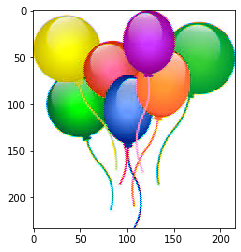

In [51]:
plt.imshow(test0, interpolation='nearest')

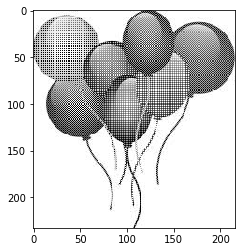

In [52]:
image_test = [
        mosaiced_images[0],
        mosaiced_images[0],
        mosaiced_images[0],
    ]
plt.imshow(np.stack(image_test,axis=-1),interpolation='nearest')

In [8]:
def calculate_mean_difference(output_images):
    sum = 0.0
    for idx, image in enumerate(output_images):
        pixel_error = np.absolute(image - gtruth_images[idx])
        sum += np.mean(pixel_error)
    sum /= len(output_images)
    
    return sum

In [53]:
def calcuate_difference(image):
    sum = 0.0
    error = np.absolute(image - gtruth_images[0])
    return np.mean(error)
    

calcuate_difference(test0)

0.01934434294037649

In [54]:
def demosaic_interpolate(im):
    '''
    Implement your linear interpolation code here.
    '''
    # averge value of your neighbours
    # missing neighbour: mirror padding: reflect padding based on edges
    pad_size = 1
    image_padding = np.pad(im,pad_size,'reflect')
    
    # G channel image
    # the interpolation of R pixels
    g_image_linear = im.copy()
    g_temp_padding = image_padding.copy()
    for x in range(1,g_temp_padding.shape[0]-pad_size,2):
        for y in range(1,g_temp_padding.shape[1]-pad_size,2):
            g_temp_padding[x,y] = g_temp_padding[x,y-1] + g_temp_padding[x,y+1] + g_temp_padding[x-1,y] + g_temp_padding[x+1,y]
            g_temp_padding[x,y] = g_temp_padding[x,y] / 4.0
    # the interpolation of B pixels
    for x in range(2,g_temp_padding.shape[0]-pad_size,2):
        for y in range(2,g_temp_padding.shape[1]-pad_size,2):
            g_temp_padding[x,y] = g_temp_padding[x,y-1] + g_temp_padding[x,y+1] + g_temp_padding[x-1,y] + g_temp_padding[x+1,y]
            g_temp_padding[x,y] = g_temp_padding[x,y] / 4.0
    # crop the padding G image
    g_image_linear = g_temp_padding[pad_size:g_temp_padding.shape[0]-pad_size,pad_size:g_temp_padding.shape[1]-pad_size]
    
    # R channel image
    r_image_linear = im.copy()
    r_temp_padding = image_padding.copy()
    # the interpolation of G pixels
    #same row: average value of left nearest and right nearest: horizontal direction
    for x in range(1,r_temp_padding.shape[0]-pad_size,2):
        for y in range(2,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = ( r_temp_padding[x,y-1] + r_temp_padding[x,y+1] ) / 2.0  
    #same column: average value of top nearest and below nearest: vertical direction
    for x in range(2,r_temp_padding.shape[0]-pad_size,2):
        for y in range(1,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = ( r_temp_padding[x-1,y] + r_temp_padding[x+1,y] ) / 2.0  

    # the interpolation of B pixels
    # based on the interpolated G pixels
    for x in range(2,r_temp_padding.shape[0]-pad_size,2):
        for y in range(2,r_temp_padding.shape[1]-pad_size,2):
            r_temp_padding[x,y] = r_temp_padding[x,y-1] + r_temp_padding[x,y+1] + r_temp_padding[x-1,y] + r_temp_padding[x+1,y]
            r_temp_padding[x,y] = r_temp_padding[x,y] / 4.0
    
    #crop the padding R image
    r_image_linear = r_temp_padding[pad_size:r_temp_padding.shape[0]-pad_size,pad_size:r_temp_padding.shape[1]-pad_size]
    
    
    # B channel image
    b_image_linear = im.copy()
    b_temp_padding = image_padding.copy()
    # the interpolation of G pixels
    # same row: average value of left nearest and right nearest: horizontal direction
    for x in range(2,b_temp_padding.shape[0]-pad_size,2):
        for y in range(1,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = ( b_temp_padding[x,y-1] + b_temp_padding[x,y+1] ) / 2.0  
    # same column: average value of top nearest and below nearest: vertical direction
    for x in range(1,b_temp_padding.shape[0]-pad_size,2):
        for y in range(2,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = ( b_temp_padding[x-1,y] + b_temp_padding[x+1,y] ) / 2.0 
            
    # the interpolation of R pixels
    # based on the interpolated G pixels
    for x in range(1,b_temp_padding.shape[0]-pad_size,2):
        for y in range(1,b_temp_padding.shape[1]-pad_size,2):
            b_temp_padding[x,y] = b_temp_padding[x,y-1] + b_temp_padding[x,y+1] + b_temp_padding[x-1,y] + b_temp_padding[x+1,y]
            b_temp_padding[x,y] = b_temp_padding[x,y] / 4.0
    #crop the padding B image
    b_image_linear = b_temp_padding[pad_size:b_temp_padding.shape[0]-pad_size,pad_size:b_temp_padding.shape[1]-pad_size]
    
    #return np.zeros((im.shape[0], im.shape[1], 3))
    final_image_linear = [
        r_image_linear,
        g_image_linear,
        b_image_linear
    ]
    return final_image_linear

In [36]:
test1 = demosaic_interpolate(mosaiced_images[0])

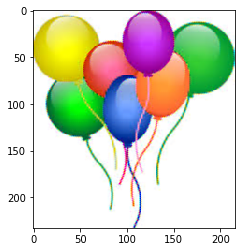

In [38]:
plt.imshow(np.stack(test1,axis=-1), interpolation='nearest')

In [39]:
 calcuate_difference(test1)

ValueError: operands could not be broadcast together with shapes (3,233,216) (233,216,3) 

In [40]:
test10 = np.stack(test1,axis=-1)

In [41]:
test10.shape

(233, 216, 3)

In [44]:
calcuate_difference(test10)

0.012875120906201722

In [45]:
abs(10-1)

9

In [46]:
np.absolute(10-1)

9

In [55]:
def demosaic_gradient(im):
    '''
    Implement your gradient-based code here.
    '''
    # average based on nbhd structure
    # missing neighbour: mirror padding: reflect padding based on edges
    pad_size = 1
    image_padding_gradient = np.pad(im,pad_size,'reflect')
    
    # G channel image
    # the interpolation of R pixels
    g_image_gradient = im.copy()
    g_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = g_temp_padding_gradient.shape[0]
    len_col = g_temp_padding_gradient.shape[1]
    for x in range(1,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            abtb = abs(g_temp_padding_gradient[x-1,y] - g_temp_padding_gradient[x+1,y])
            ablr = abs(g_temp_padding_gradient[x,y-1] - g_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x,y-1] + g_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x-1,y] + g_temp_padding_gradient[x+1,y]) / 2.0
    # the interpolation of B pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            abtb = abs(g_temp_padding_gradient[x-1,y] - g_temp_padding_gradient[x+1,y])
            ablr = abs(g_temp_padding_gradient[x,y-1] - g_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x,y-1] + g_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                g_temp_padding_gradient[x,y] = (g_temp_padding_gradient[x-1,y] + g_temp_padding_gradient[x+1,y]) / 2.0
           
    # crop the padding G image
    g_image_gradient = g_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    
    # R channel image
    r_image_gradient = im.copy()
    r_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = r_temp_padding_gradient.shape[0]
    len_col = r_temp_padding_gradient.shape[1]
    
    # the interpolation of G 
    # same row: average value of left nearest and right nearest: horizontal direction
    # no top nearest and below nearest R pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            r_temp_padding_gradient[x,y] = ( r_temp_padding_gradient[x,y-1] + r_temp_padding_gradient[x,y+1] ) / 2.0  
    #same column: average value of top nearest and below nearest: vertical direction
    #no left nearest and right nearest R pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            r_temp_padding_gradient[x,y] = ( r_temp_padding_gradient[x-1,y] + r_temp_padding_gradient[x+1,y] ) / 2.0  

    # the interpolation of B pixels
    # based on the interpolated G pixels        
    for x in range(2,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            abtb = abs(r_temp_padding_gradient[x-1,y] - r_temp_padding_gradient[x+1,y])
            ablr = abs(r_temp_padding_gradient[x,y-1] - r_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                r_temp_padding_gradient[x,y] = (r_temp_padding_gradient[x,y-1] + r_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                r_temp_padding_gradient[x,y] = (r_temp_padding_gradient[x-1,y] + r_temp_padding_gradient[x+1,y]) / 2.0  
    # crop the padding R image
    r_image_gradient = r_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    
    # B channel image
    # B channel image
    b_image_gradient = im.copy()
    b_temp_padding_gradient = image_padding_gradient.copy()
    
    len_row = b_temp_padding_gradient.shape[0]
    len_col = b_temp_padding_gradient.shape[1]
    
    # the interpolation of G pixels
    # same row: average value of left nearest and right nearest: horizontal direction
    # no top nearest and below nearest B pixels
    for x in range(2,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            b_temp_padding_gradient[x,y] = ( b_temp_padding_gradient[x,y-1] + b_temp_padding_gradient[x,y+1] ) / 2.0  
    # same column: average value of top nearest and below nearest: vertical direction
    # no top nearest and below nearest B pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(2,len_col-pad_size,2):
            b_temp_padding_gradient[x,y] = ( b_temp_padding_gradient[x-1,y] + b_temp_padding_gradient[x+1,y] ) / 2.0 
            
    # the interpolation of R pixels
    # based on the interpolated G pixels
    for x in range(1,len_row-pad_size,2):
        for y in range(1,len_col-pad_size,2):
            abtb = abs(b_temp_padding_gradient[x-1,y] - b_temp_padding_gradient[x+1,y])
            ablr = abs(b_temp_padding_gradient[x,y-1] - b_temp_padding_gradient[x,y+1])
            if abtb > ablr:
                b_temp_padding_gradient[x,y] = (b_temp_padding_gradient[x,y-1] + b_temp_padding_gradient[x,y+1] )/ 2.0
            else:
                b_temp_padding_gradient[x,y] = (b_temp_padding_gradient[x-1,y] + b_temp_padding_gradient[x+1,y]) / 2.0 
           
    #crop the padding B image
    b_image_gradient = b_temp_padding_gradient[pad_size:len_row-pad_size, pad_size:len_col-pad_size]
    
    #return np.zeros((im.shape[0], im.shape[1], 3))
    final_image_gradient = [
       r_image_gradient,
       g_image_gradient,
       b_image_gradient
    ]
    
    return final_image_gradient


In [56]:
test20 = demosaic_gradient(mosaiced_images[0])

In [57]:
test20.shape

AttributeError: 'list' object has no attribute 'shape'

In [58]:
test20 = np.stack(test20,axis=-1)

In [59]:
test20.shape()

TypeError: 'tuple' object is not callable

In [60]:
test20.shape

(233, 216, 3)

In [61]:
calcuate_difference(test20)

0.012018264758348635